# **Machine Learning - Proyecto: Predicción de Retrasos de Vuelos** ✈️

## Librerías

### Librerías Generales

In [1]:
import pandas as pd
import numpy as np
import time
import joblib
import os
import warnings

warnings.filterwarnings('ignore')

### Librerías de Machine Learning

In [2]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    roc_auc_score, 
    precision_recall_curve, 
    auc
)
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de visualización
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

# 1. Carga de Datos

In [3]:
file_path =  r"d:\OneDrive\DOCUMENTOS\Personales\2024\uniandes\8 S\seminario\g11-caso-estudio-flights\data\processed\flights_clean.csv"

try:
    df = pd.read_csv(file_path)
    print(f"Datos cargados exitosamente desde '{file_path}'.")
    print("\nInformación del DataFrame:")
    df.info()
    print("\nPrimeras 5 filas:")
    print(df.head())
except FileNotFoundError:
    print(f"Error: No se encontró el archivo en {file_path}")
except Exception as e:
    print(f"Error al cargar el archivo: {e}")

Datos cargados exitosamente desde 'd:\OneDrive\DOCUMENTOS\Personales\2024\uniandes\8 S\seminario\g11-caso-estudio-flights\data\processed\flights_clean.csv'.

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5231130 entries, 0 to 5231129
Data columns (total 41 columns):
 #   Column               Dtype  
---  ------               -----  
 0   MONTH                int64  
 1   DAY                  int64  
 2   DAY_OF_WEEK          int64  
 3   AIRLINE              object 
 4   ORIGIN_AIRPORT       object 
 5   DESTINATION_AIRPORT  object 
 6   SCHEDULED_DEPARTURE  int64  
 7   DEPARTURE_TIME       float64
 8   DEPARTURE_DELAY      float64
 9   SCHEDULED_TIME       float64
 10  DISTANCE             int64  
 11  SCHEDULED_ARRIVAL    int64  
 12  ARRIVAL_TIME         float64
 13  ARRIVAL_DELAY        float64
 14  AIRLINE_NAME         object 
 15  ORIGEN_AEROPUERTO    object 
 16  ORIGEN_CIUDAD        object 
 17  ORIGEN_ESTADO        object 
 18  ORIGEN_LAT       

In [4]:
df.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_TIME,...,MIN_SALIDA,MIN_LLEGADA,MINUTO_DIA_SALIDA,MINUTO_DIA_LLEGADA,SALIDA_SIN,SALIDA_COS,LLEGADA_SIN,LLEGADA_COS,PERIODO_SALIDA,PERIODO_LLEGADA
0,1,1,4,AS,ANC,SEA,5,2354.0,-11.0,205.0,...,5,30,5,270,0.021815,0.999762,0.923880,0.382683,Madrugada,Madrugada
1,1,1,4,AA,LAX,PBI,10,2.0,-8.0,280.0,...,10,50,10,470,0.043619,0.999048,0.887011,-0.461749,Madrugada,Mañana
2,1,1,4,US,SFO,CLT,20,18.0,-2.0,286.0,...,20,6,20,486,0.087156,0.996195,0.852640,-0.522499,Madrugada,Mañana
3,1,1,4,AA,LAX,MIA,20,15.0,-5.0,285.0,...,20,5,20,485,0.087156,0.996195,0.854912,-0.518773,Madrugada,Mañana
4,1,1,4,AS,SEA,ANC,25,24.0,-1.0,235.0,...,25,20,25,200,0.108867,0.994056,0.766044,0.642788,Madrugada,Madrugada


In [5]:

# assert "RETRASADO_LLEGADA" in v.columns, "No existe la columna RETRASADO_LLEGADA en el dataset limpio."

conteo = df["RETRASADO_LLEGADA"].value_counts().sort_index()
porc = (conteo / conteo.sum() * 100).round(2)

print("📊 Distribución de vuelos según retraso en llegada (>15 min):\n")
print(f"A tiempo (0): {conteo.get(0,0):,} vuelos ({porc.get(0,0):.2f}%)")
print(f"Retrasados (1): {conteo.get(1,0):,} vuelos ({porc.get(1,0):.2f}%)")

📊 Distribución de vuelos según retraso en llegada (>15 min):

A tiempo (0): 4,264,869 vuelos (81.53%)
Retrasados (1): 966,261 vuelos (18.47%)


# 2. Selección de Características y Objetivo

In [6]:
# Variable objetivo (Target)
target_variable = 'RETRASADO_LLEGADA'

# Variables predictoras (Features)
# Usamos las variables que se conocen *antes* del despegue.
features = [
    'AIRLINE', 
    'ORIGIN_AIRPORT', 
    'DESTINATION_AIRPORT', 
    'MONTH', 
    'DAY_OF_WEEK', 
    'SCHEDULED_TIME', 
    'DISTANCE',
    'SALIDA_SIN',  # Componente cíclica de la hora de salida
    'SALIDA_COS',  # Componente cíclica de la hora de salida
    'LLEGADA_SIN', # Componente cíclica de la hora de llegada
    'LLEGADA_COS'  # Componente cíclica de la hora de llegada
]

# Separar categóricas y numéricas para el modelo
categorical_features = ['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'MONTH', 'DAY_OF_WEEK']
numerical_features = [f for f in features if f not in categorical_features]

print(f"Variable Objetivo: {target_variable}")
print(f"\nCaracterísticas Numéricas: {numerical_features}")
print(f"\nCaracterísticas Categóricas: {categorical_features}")

Variable Objetivo: RETRASADO_LLEGADA

Características Numéricas: ['SCHEDULED_TIME', 'DISTANCE', 'SALIDA_SIN', 'SALIDA_COS', 'LLEGADA_SIN', 'LLEGADA_COS']

Características Categóricas: ['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'MONTH', 'DAY_OF_WEEK']


# 3. Preprocesamiento de Datos

## 3.1. Conversión de Tipos para LightGBM

In [7]:
# LightGBM puede manejar variables categóricas de forma nativa si se marcan con el tipo 'category'.
# Esto es mucho más eficiente que One-Hot Encoding.

# Creamos un DataFrame solo con las columnas necesarias
try:
    df_model = df[features + [target_variable]].copy()
    
    # Convertir categóricas al tipo 'category'
    for col in categorical_features:
        df_model[col] = df_model[col].astype('category')
        
    print("Tipos de datos después de la conversión:")
    print(df_model.info())
except NameError:
    print("Error: El DataFrame 'df' no se cargó correctamente.")
except Exception as e:
    print(f"Error en el preprocesamiento: {e}")

Tipos de datos después de la conversión:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5231130 entries, 0 to 5231129
Data columns (total 12 columns):
 #   Column               Dtype   
---  ------               -----   
 0   AIRLINE              category
 1   ORIGIN_AIRPORT       category
 2   DESTINATION_AIRPORT  category
 3   MONTH                category
 4   DAY_OF_WEEK          category
 5   SCHEDULED_TIME       float64 
 6   DISTANCE             int64   
 7   SALIDA_SIN           float64 
 8   SALIDA_COS           float64 
 9   LLEGADA_SIN          float64 
 10  LLEGADA_COS          float64 
 11  RETRASADO_LLEGADA    int64   
dtypes: category(5), float64(5), int64(2)
memory usage: 314.3 MB
None


## 3.2. División de Datos (Train/Test Split)

In [8]:
# Separar X (features) e y (target)
try:
    X = df_model[features]
    y = df_model[target_variable]

    # Dividir en entrenamiento (80%) y prueba (20%)
    # Usamos 'stratify=y' para asegurar que la proporción de retrasos sea la misma en train y test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42, 
        stratify=y
    )

    print(f"Tamaño de X_train: {X_train.shape}")
    print(f"Tamaño de X_test: {X_test.shape}")
    print(f"Proporción de retrasos en y_train: {y_train.mean():.4f}")
    print(f"Proporción de retrasos en y_test: {y_test.mean():.4f}")

except NameError:
    print("Error: X o y no están definidos. Revisar la celda anterior.")
except Exception as e:
    print(f"Error en la división de datos: {e}")

Tamaño de X_train: (4184904, 11)
Tamaño de X_test: (1046226, 11)
Proporción de retrasos en y_train: 0.1847
Proporción de retrasos en y_test: 0.1847


# 4. Entrenamiento del Modelo (LightGBM)

## 4.1. Manejo del Desbalanceo

In [9]:
# El dataset está desbalanceado (~18.47% positivos).
# Usaremos 'scale_pos_weight' para que el modelo preste más atención a la clase minoritaria (retrasos).

try:
    conteo_negativos = y_train.value_counts()[0]
    conteo_positivos = y_train.value_counts()[1]
    
    # Ratio = (Conteo Negativos) / (Conteo Positivos)
    ratio_balanceo = conteo_negativos / conteo_positivos

    print(f"Conteo 'A Tiempo' (0): {conteo_negativos}")
    print(f"Conteo 'Retrasado' (1): {conteo_positivos}")
    print(f"Ratio de balanceo (scale_pos_weight): {ratio_balanceo:.2f}")

except NameError:
    print("Error: 'y_train' no definido.")
except Exception as e:
    print(f"Error calculando el ratio: {e}")

Conteo 'A Tiempo' (0): 3411895
Conteo 'Retrasado' (1): 773009
Ratio de balanceo (scale_pos_weight): 4.41


## 4.2. Instanciar y Entrenar el Modelo

In [10]:
try:
    start_time = time.time()

    # Instanciar el clasificador LightGBM
    lgbm_model = lgb.LGBMClassifier(
        objective='binary',          # Clasificación binaria
        metric='average_precision',  # AUC-PR, excelente para desbalanceo
        n_estimators=1000,           # Número de árboles (alto, pero usaremos early stopping)
        learning_rate=0.05,
        n_jobs=-1,                   # Usar todos los cores
        random_state=42,
        scale_pos_weight=ratio_balanceo  # Aplicar el balanceo
        # Alternativa: is_unbalance=True
    )

    print("Iniciando entrenamiento del modelo LGBM...")

    # Entrenar el modelo
    lgbm_model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],  # Usar set de prueba para Early Stopping
        eval_metric='average_precision',
        callbacks=[lgb.early_stopping(100, verbose=True)], # Parar si no mejora en 100 rondas
        categorical_feature=categorical_features  # Indicar columnas categóricas
    )

    end_time = time.time()
    print(f"\nEntrenamiento completado en {end_time - start_time:.2f} segundos.")

except NameError:
    print("Error: Faltan variables (X_train, y_train, ratio_balanceo) para el entrenamiento.")
except Exception as e:
    print(f"Error durante el entrenamiento: {e}")

Iniciando entrenamiento del modelo LGBM...
[LightGBM] [Info] Number of positive: 773009, number of negative: 3411895
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2072
[LightGBM] [Info] Number of data points in the train set: 4184904, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.184714 -> initscore=-1.484732
[LightGBM] [Info] Start training from score -1.484732
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's average_precision: 0.35126

Entrenamiento completado en 296.72 segundos.


# 5. Evaluación del Modelo

## 5.1. Reporte de Clasificación

In [11]:
# Generar predicciones en el conjunto de prueba
try:
    y_pred = lgbm_model.predict(X_test)
    y_pred_proba = lgbm_model.predict_proba(X_test)[:, 1] # Probabilidad de la clase '1'

    print("Reporte de Clasificación (Test Set):")
    print(classification_report(y_test, y_pred, target_names=['A Tiempo (0)', 'Retrasado (1)']))
    
    # Nota: Gracias al balanceo, el 'recall' para 'Retrasado (1)' debería ser mucho mejor
    # que si no hubiéramos balanceado, aunque la 'precision' pueda bajar un poco.

except NameError:
    print("Error: El modelo 'lgbm_model' no está entrenado o 'X_test' no está definido.")
except Exception as e:
    print(f"Error al generar predicciones: {e}")

Reporte de Clasificación (Test Set):
               precision    recall  f1-score   support

 A Tiempo (0)       0.89      0.64      0.74    852974
Retrasado (1)       0.29      0.65      0.40    193252

     accuracy                           0.64   1046226
    macro avg       0.59      0.65      0.57   1046226
 weighted avg       0.78      0.64      0.68   1046226



## 5.2. Matriz de Confusión

Matriz de Confusión (Test Set):


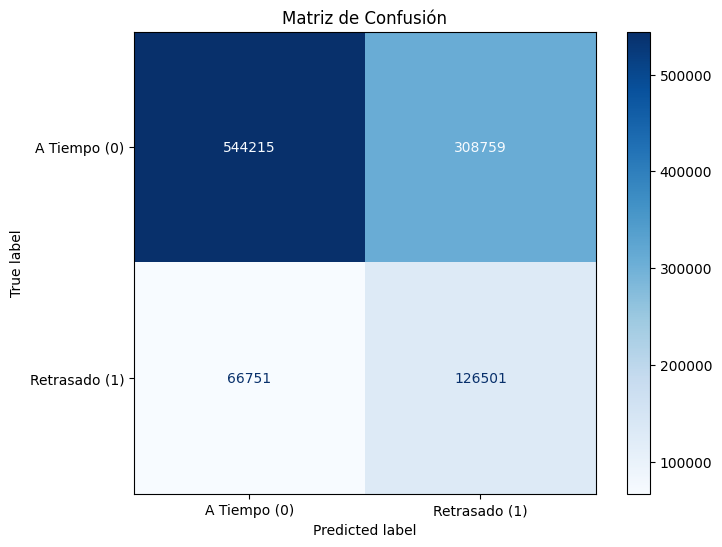

In [12]:
# Visualizar la Matriz de Confusión
try:
    print("Matriz de Confusión (Test Set):")
    
    # Usar la función moderna de Scikit-learn para graficar
    fig, ax = plt.subplots(figsize=(8, 6))
    ConfusionMatrixDisplay.from_estimator(
        lgbm_model, X_test, y_test, 
        display_labels=['A Tiempo (0)', 'Retrasado (1)'], 
        cmap='Blues', 
        normalize=None, 
        ax=ax
    )
    plt.title('Matriz de Confusión')
    plt.grid(False)
    plt.show()

except NameError:
    print("Error: El modelo 'lgbm_model' no está entrenado.")
except Exception as e:
    print(f"Error al graficar la matriz de confusión: {e}")

## 5.3. Curvas de Evaluación (AUC-ROC y AUC-PR)

AUC-ROC Score: 0.7023
AUC-PR Score (Area Under Precision-Recall Curve): 0.3513


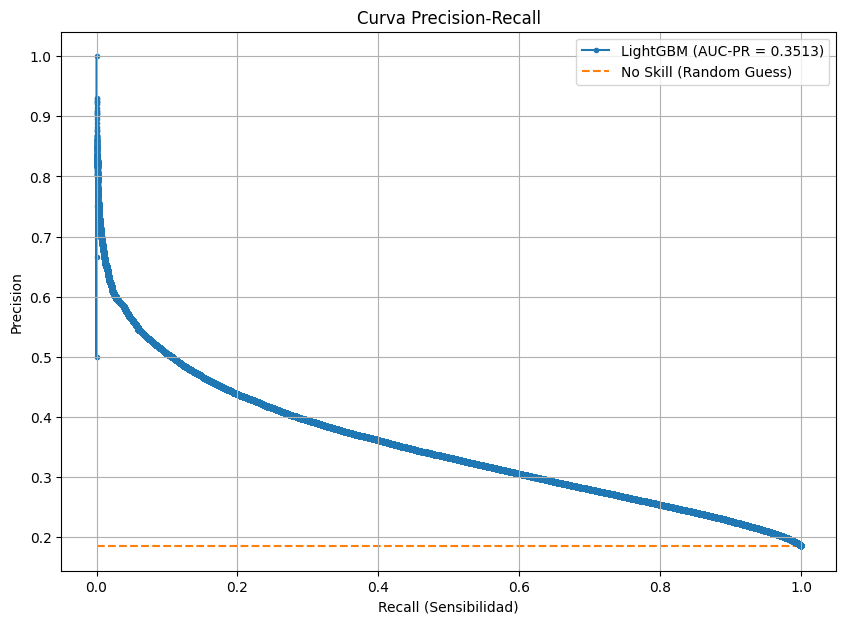

In [13]:
# Para problemas desbalanceados, la curva Precision-Recall (AUC-PR) 
# es a menudo más informativa que la curva ROC (AUC-ROC).
try:
    # 1. AUC-ROC Score
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    print(f"AUC-ROC Score: {auc_roc:.4f}")

    # 2. AUC-PR Score
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    auc_pr = auc(recall, precision)
    print(f"AUC-PR Score (Area Under Precision-Recall Curve): {auc_pr:.4f}")

    # 3. Graficar Curva PR
    plt.figure(figsize=(10, 7))
    plt.plot(recall, precision, marker='.', label=f'LightGBM (AUC-PR = {auc_pr:.4f})', zorder=1)
    # Línea de 'no skill' (predicción aleatoria para esta proporción de clase)
    no_skill = conteo_positivos / (conteo_positivos + conteo_negativos)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill (Random Guess)', zorder=0)
    plt.title('Curva Precision-Recall')
    plt.xlabel('Recall (Sensibilidad)')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)
    plt.show()

except NameError:
    print("Error: 'y_pred_proba' o 'y_test' no están definidos.")
except Exception as e:
    print(f"Error al calcular curvas: {e}")

# 6. Importancia de Características

Importancia de Características (por 'Gain'):


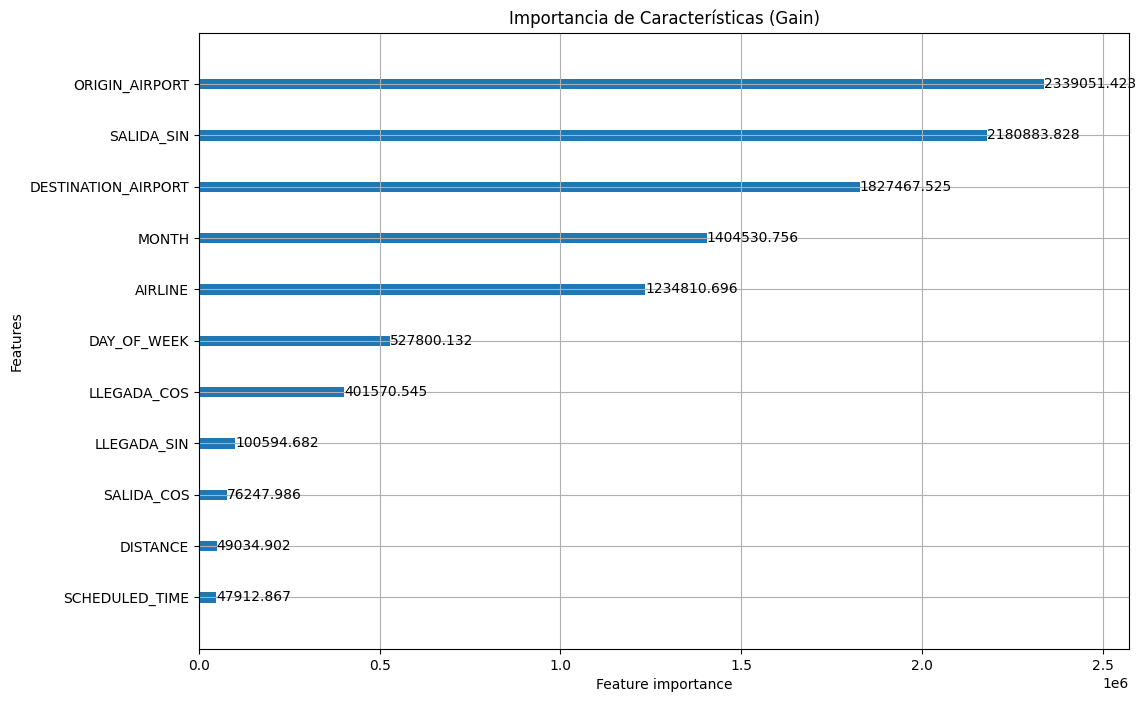

Importancia de Características (por 'Split'):


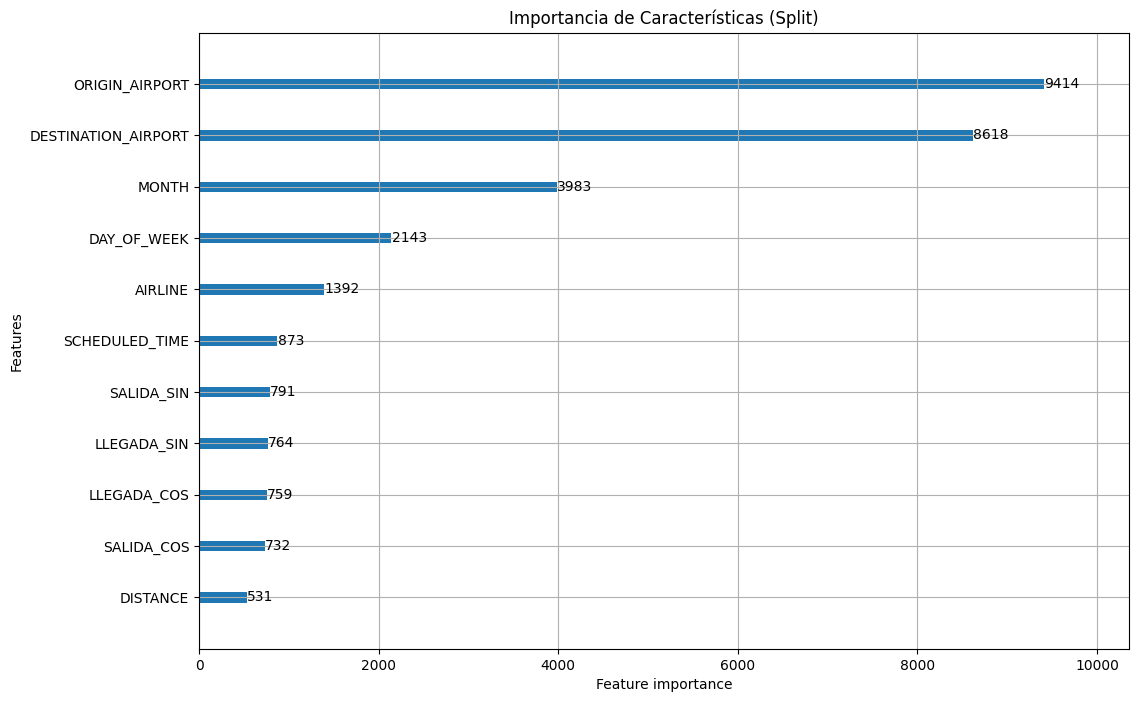

In [14]:
# Revisar qué características considera el modelo como más importantes
try:
    # Gráfico 1: Importancia por 'gain' (contribución total)
    print("Importancia de Características (por 'Gain'):")
    lgb.plot_importance(lgbm_model, max_num_features=20, figsize=(12, 8), importance_type='gain')
    plt.title('Importancia de Características (Gain)')
    plt.show()

    # Gráfico 2: Importancia por 'split' (veces usada para dividir)
    print("Importancia de Características (por 'Split'):")
    lgb.plot_importance(lgbm_model, max_num_features=20, figsize=(12, 8), importance_type='split')
    plt.title('Importancia de Características (Split)')
    plt.show()

except NameError:
    print("Error: El modelo 'lgbm_model' no está entrenado.")
except Exception as e:
    print(f"Error al graficar importancia: {e}")

# 7. Guardar Modelo

In [15]:
# Guardar el modelo entrenado para usarlo en el futuro (ej. en una API)
model_filename = 'lgbm_flight_delay_model.joblib'

try:
    joblib.dump(lgbm_model, model_filename)
    print(f"Modelo guardado exitosamente en: {model_filename}")
    
    # Ejemplo de cómo cargarlo:
    # print("\nCargando modelo...")
    # loaded_model = joblib.load(model_filename)
    # print("Modelo cargado.")
    
except NameError:
    print("Error: El modelo 'lgbm_model' no existe para guardar.")
except Exception as e:
    print(f"Error al guardar el modelo: {e}")

Modelo guardado exitosamente en: lgbm_flight_delay_model.joblib


"Ajuste del Umbral de Decisión"


--- Reporte de Clasificación con Umbral = 0.4 ---
               precision    recall  f1-score   support

 A Tiempo (0)       0.92      0.42      0.57    852974
Retrasado (1)       0.24      0.84      0.38    193252

     accuracy                           0.49   1046226
    macro avg       0.58      0.63      0.48   1046226
 weighted avg       0.79      0.49      0.54   1046226

--- Matriz de Confusión con Umbral = 0.4 ---


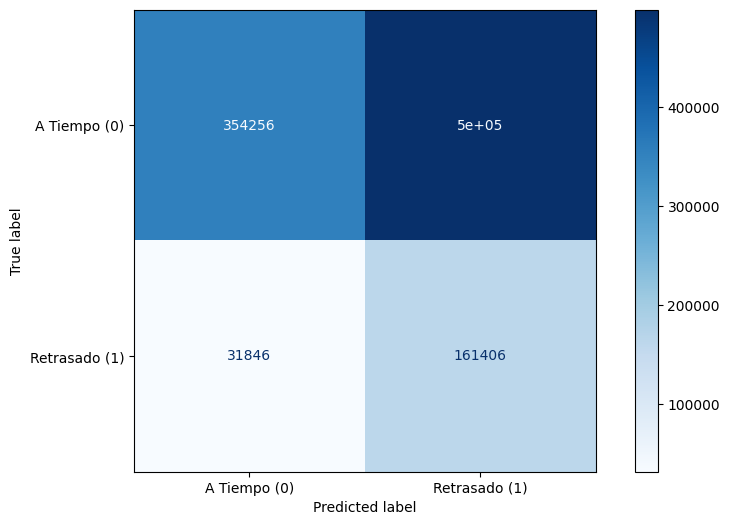

In [16]:
# 1. Obtener las probabilidades (ya lo hiciste, pero lo repetimos por claridad)
y_pred_proba = lgbm_model.predict_proba(X_test)[:, 1]

# 2. Definir un NUEVO umbral.
# Juega con este valor. Empecemos con 0.4 para intentar subir el Recall.
nuevo_umbral = 0.40 

# 3. Crear nuevas predicciones basadas en el nuevo umbral
# Esto es 'True' (1) si la proba es >= 0.40, y 'False' (0) si no.
y_pred_nuevo_umbral = (y_pred_proba >= nuevo_umbral).astype(int)

# 4. Evaluar los resultados con este nuevo umbral
print(f"--- Reporte de Clasificación con Umbral = {nuevo_umbral} ---")
print(classification_report(y_test, y_pred_nuevo_umbral, target_names=['A Tiempo (0)', 'Retrasado (1)']))

# 5. Ver la nueva Matriz de Confusión
print(f"--- Matriz de Confusión con Umbral = {nuevo_umbral} ---")
cm = confusion_matrix(y_test, y_pred_nuevo_umbral)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['A Tiempo (0)', 'Retrasado (1)'])
disp.plot(cmap='Blues', xticks_rotation='horizontal')
plt.grid(False)
plt.show()

In [17]:
# Código para encontrar el umbral con el mejor F1-Score
from sklearn.metrics import precision_recall_curve, f1_score

# Obtener precision, recall y umbrales
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Calcular el F1-Score para cada umbral
# Nota: thresholds tiene un elemento menos, por eso usamos [:-1]
f1_scores = (2 * precision * recall) / (precision + recall)
f1_scores = f1_scores[:-1]

# Encontrar el índice (la posición) del F1-Score más alto
ix = np.argmax(f1_scores)

print(f"Mejor Umbral: {thresholds[ix]:.4f}")
print(f"Mejor F1-Score: {f1_scores[ix]:.4f}")
print(f"  Con Precision: {precision[ix]:.4f}")
print(f"  Con Recall: {recall[ix]:.4f}")

# Puedes usar este "mejor umbral" en el código de arriba

Mejor Umbral: 0.5280
Mejor F1-Score: 0.4049
  Con Precision: 0.3071
  Con Recall: 0.5938
